## IMPORTS & SETTINGS
Here everything is configured and the necessary libraries are imported.

In [1]:
import os
import time
import json
import yaml
import tqdm
import spotipy
import skimage
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

from tqdm.notebook import tqdm as t_
from skimage import io
from spotipy.oauth2 import SpotifyClientCredentials

# PACKAGE VERSIONS
print(f"TQDM version: {tqdm.__version__}")
# print(f"Spotify version: {spotipy.__version__}") # Doesnt exist???
print(f"Skimage version: {skimage.__version__}")
print(f"Matplotlib version: {matplotlib.__version__}")
print(f"Pandas version: {pd.__version__}")

# GET CONFIG
config_file = "settings.yml"
with open(config_file, "r") as ymlfile:
    cfg = yaml.safe_load(ymlfile)

# WAIT TIME AFTER EACH API CALL
WAIT_TIME_S = 1.5 # max 20 calls per 30 seconds

TQDM version: 4.64.1
Skimage version: 0.21.0
Matplotlib version: 3.6.3
Pandas version: 1.5.3


In [2]:
# SPOTIFY AUTH
spotify_creds = cfg["spotify_creds"]

auth_manager = SpotifyClientCredentials(
    client_id=spotify_creds["client_id"],
    client_secret=spotify_creds["client_secret"],
)

sp = spotipy.Spotify(
    auth_manager=auth_manager,
)

## HELPER FUNCTIONS
These functions are used to make the code more readable and to avoid repetition.

In [3]:
def w(result):
    """Wait for a set amount of time before returning the result."""
    time.sleep(WAIT_TIME_S)
    return result

In [4]:
def search_artist(artist_name, sp):
    # GET START ARTIST
    results = sp.search(q=f"artist:{artist_name}", type="artist")["artists"]

    if len(results["items"]) == 0:
        raise ValueError(f"No artist found with name: {artist_name}")

    if len(results["items"]) > 1:
        print(f"Multiple artists found, picking the most popular one:\n")

    artist = results["items"][0]
    print(f"Artist ID: {artist['id']}")

    plt.figure(figsize=(4, 4))
    plt.title(f"Artist: {artist['name']}")
    plt.imshow(io.imread(artist["images"][0]["url"]))
    plt.axis("off")
    plt.show()

    return artist

In [5]:
def get_artist_releases(artist_id, sp):
    """GET ALL RELEASES FROM AN ARTIST AND RETURN ALL RESPONSES IN A LIST"""
    n_singles = 0
    releases = []
    while True:
        response = w(sp.artist_albums(artist_id, limit=50, offset=n_singles))
        releases.extend(response["items"])
        if not response["next"]:
            break
        n_singles += 50

    # FILTER OUT RELEASES ON ARTIST ID
    clean_releases = []
    for release in releases:
        for artist in release["artists"]:
            if artist["id"] == artist_id:
                clean_releases.append(release)
                break

    return clean_releases

def get_artist_tracks(releases, sp):
    """GET ALL TRACKS FROM AN ARTIST'S RELEASES AND RETURN ALL RESPONSES IN A LIST"""
    tracks = []
    for i in range(0, len(releases), 20):
        album_ids = [release["id"] for release in releases[i : i + 20]]
        albums = w(sp.albums(album_ids))
        for album in albums["albums"]:
            tracks.extend(iter(album["tracks"]["items"]))

    return tracks

def save_related_artists(tracks, sp):
    """GET ALL ARTISTS IN ALL TRACKS AND SAVE THEIR INFO TO FILE"""

    scraped_artists = set({artist.split(".")[0] for artist in os.listdir("data/artists_info/")})
    artist_ids = set({artist["id"] for track in tracks for artist in track["artists"]})
    artist_ids = list(artist_ids - scraped_artists)
    for i in range(0, len(artist_ids), 50):
        artist_ids_ = artist_ids[i : i + 50]
        response = w(sp.artists(artist_ids_))
        for artist in response["artists"]:
            if not os.path.exists(f"data/artists_info/{artist['id']}.json"):
                with open(f"data/artists_info/{artist['id']}.json", "w") as f:
                    json.dump(artist, f)

def get_tracks_info(tracks, sp):
    """GET INFO ON ALL THE TRACKS"""

    # GET INFO AND AUDIO FEATURES OF 100 TRACKS AT A TIME
    tracks_info = []
    tracks_audio_features = []
    for i in range(0, len(tracks), 50):
        tracks_ids = [track["id"] for track in tracks[i : i + 50]]
        af = w(sp.audio_features(tracks_ids))
        ti = w(sp.tracks(tracks_ids))["tracks"]

        tracks_info.extend(iter(ti))
        tracks_audio_features.extend(iter(af))

    return tracks_info, tracks_audio_features


def scrape_artist(artist_id, sp):
    # CREATE NEEDED FOLDERS
    os.makedirs("data/artists_info/", exist_ok=True)
    os.makedirs("data/artists_discography/", exist_ok=True)
    os.makedirs("data/tracks_audio_features/", exist_ok=True)

    # CHECK IF ALREADY SCRAPED
    if os.path.exists(f"data/artists_discography/{artist_id}/"):
        print(f"Artist {artist_id} already scraped")
        return 0

    # GET ARTIST TRACKS
    releases = get_artist_releases(artist_id, sp)
    tracks = get_artist_tracks(releases, sp)

    # EARLY RETURN IF NO TRACKS
    if len(releases) == 0:
        os.makedirs(f"data/artists_discography/{artist_id}/")
        return 0

    # SAVE INFO ON RELATED ARTISTS AND GET TRACK INFOS
    save_related_artists(tracks, sp)
    tracks_info, tracks_audio_features = get_tracks_info(tracks, sp)

    # REMOVE NONE VALUES
    tracks_info = [track for track in tracks_info if track]
    tracks_audio_features = [track for track in tracks_audio_features if track]

    # IF EVERYTHING WENT WELL, SAVE ALL TRACKS
    os.makedirs(f"data/artists_discography/{artist_id}/")
    for track in tracks_info:
        with open(f"data/artists_discography/{artist_id}/{track['id']}.json", "w") as f:
            json.dump(track, f)
    for track_audio_features in tracks_audio_features:
        if not os.path.exists(f"data/tracks_audio_features/{track_audio_features['id']}.json"):
            with open(f"data/tracks_audio_features/{track_audio_features['id']}.json", "w") as f:
                json.dump(track_audio_features, f)
    return 0

## FUN
Here we do all the work. 

In [6]:
# PARAMS
start_artist_name = "Illenium"
connection_depth = 1

Multiple artists found, picking the most popular one:

Artist ID: 45eNHdiiabvmbp4erw26rg


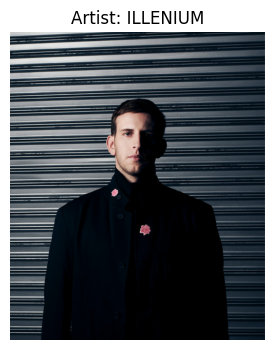

In [7]:
# SEARCH FOR START ARTIST
start_artist = search_artist(start_artist_name, sp)

In [8]:
# SCRAPED DATA FROM INITIAL ARTIST
scrape_artist(start_artist["id"], sp)

# SCRAPE ALL THE RELATED ARTISTS ITERATIVELY
for i in range(0, connection_depth):
    print(f"Scraping artists at depth: {i+1}")

    searched_artists = [artist.split(".")[0] for artist in os.listdir("data/artists_discography/")]
    artists_to_search = [artist.split(".")[0] for artist in os.listdir("data/artists_info/")]
    artists_to_search = list(set(artists_to_search) - set(searched_artists))

    for artist_id in t_(artists_to_search):
        return_code = -1
        while return_code == -1:
            try:
                return_code = scrape_artist(artist_id, sp)
            except Exception as e:
                print(f"Error scraping artist {artist_id}: {e}")
                os.system(f"rm -r data/artists_discography/{artist_id}")
                time.sleep(60)

Scraping artists at depth: 1


  0%|          | 0/246 [00:00<?, ?it/s]